In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('aluminium_raw_inputs.csv')

In [ ]:
df["log_returns"] = np.log(df["al_lme_prices"] / df["al_lme_prices"].shift(1))
df = df.dropna()
df["vol"] = df["log_returns"].rolling(window=30).std() * np.sqrt(252)

In [3]:
df["target_vol"] = df["vol"].shift(-30) # the target volatility is the next 30 days' volatility
df["target_log_vol"] = np.log(df["target_vol"] + 1e-8)
df = df.dropna()

In [4]:
df['lag1_vol']  = df['vol'].shift(1)
df['lag7_vol']  = df['vol'].shift(7)
df['lag30_vol']  = df['vol'].shift(30)
df = df.dropna()

In [5]:
len(df)

2356

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

X_df = df.drop(columns=['target_vol', 'date']).reset_index(drop=True)
y_df = df['target_vol'].reset_index(drop=True)  # Series is fine

In [ ]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X = X_scaler.fit_transform(X_df)                           
y = y_scaler.fit_transform(y_df.values.reshape(-1, 1)).ravel()

In [8]:
import torch
import numpy as np
import random

seed = 42

# PyTorch seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# NumPy seed
np.random.seed(seed)

# Python's built-in random
random.seed(seed)


Shapes — train (2003, 52)  test (353, 52)
[FROZEN] GARCH(1,1) 30d log-Vol MSE  = 0.072081
[FROZEN] GARCH(1,1) 30d log-Vol MAE  = 0.218454
omega  3.5669318514603126e-06
alpha 0.05
beta 0.9299999999999999
alpha + beta  0.98


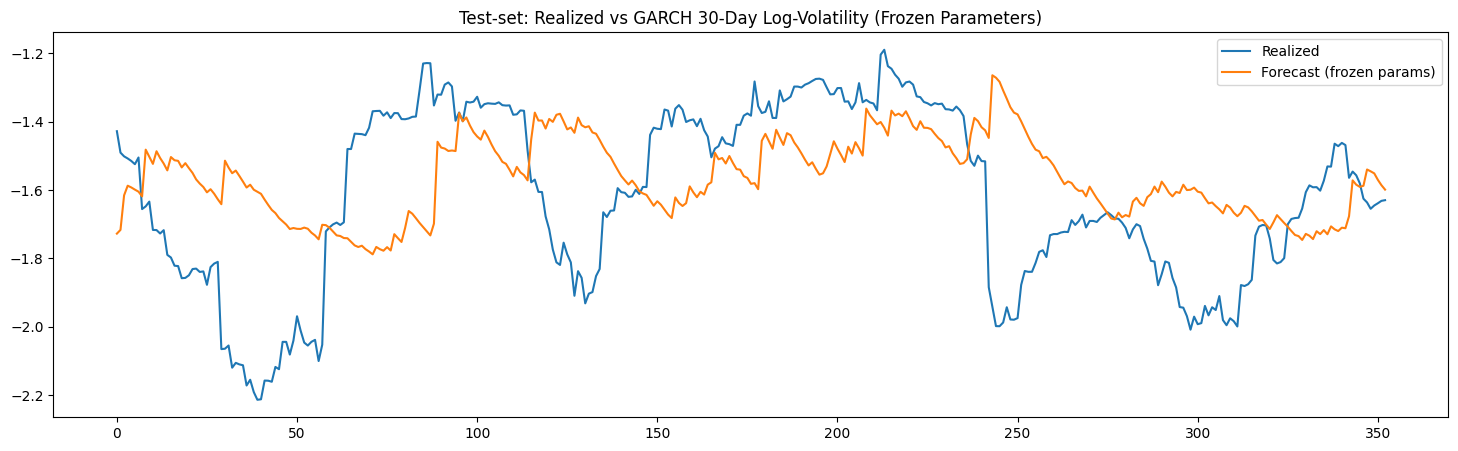

In [ ]:
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

train_ratio = 0.85
test_ratio  = 0.15

n_samples   = len(X)
n_test      = int(round(n_samples * test_ratio))
n_train     = n_samples - n_test

train_idx = np.arange(0, n_train)
test_idx  = np.arange(n_train, n_samples)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print(f"Shapes — train {X_train.shape}  test {X_test.shape}")

# Fit GARCH(1,1) once on train only, then freeze parameters

returns = df['log_returns'].values
train_returns = returns[:n_train]

am  = arch_model(train_returns, mean='Zero', vol='Garch', p=1, q=1, dist='normal')
res = am.fit(disp='off')

omega = float(res.params['omega'])
alpha = float(res.params['alpha[1]'])
beta  = float(res.params['beta[1]'])

sigma2_t = float(res.conditional_volatility[-1]**2)


H = 30  # horizon
ab = alpha + beta

log_vol_preds = np.zeros(n_test)

for i, t in enumerate(test_idx):
    r_prev = returns[t-1] 
    sigma2_t = omega + alpha * (r_prev**2) + beta * sigma2_t  


    s = sigma2_t
    path = np.empty(H)
    for h in range(H):
        s = omega + ab * s
        path[h] = s

    avg_var      = float(path.mean())
    vol_30d_hat  = np.sqrt(avg_var) * np.sqrt(252.0)
    log_vol_preds[i] = np.log(vol_30d_hat + 1e-8)

realized_log_vol = df['target_log_vol'].values[test_idx]

mse  = mean_squared_error(realized_log_vol, log_vol_preds)
mae  = mean_absolute_error(realized_log_vol, log_vol_preds)

print(f"[FROZEN] GARCH(1,1) 30d log-Vol MSE  = {mse:.6f}")
print(f"[FROZEN] GARCH(1,1) 30d log-Vol MAE  = {mae:.6f}")
print("omega ", omega)
print("alpha", alpha)
print("beta", beta)
print("alpha + beta ", beta + alpha)
plt.figure(figsize=(18,5))
plt.plot(range(len(test_idx)), realized_log_vol, label="Realized")
plt.plot(range(len(test_idx)), log_vol_preds, label="Forecast (frozen params)")
plt.legend()
plt.title('Test-set: Realized vs GARCH 30-Day Log-Volatility (Frozen Parameters)')
plt.savefig('plots/garch/test_point_log.png')
plt.show()


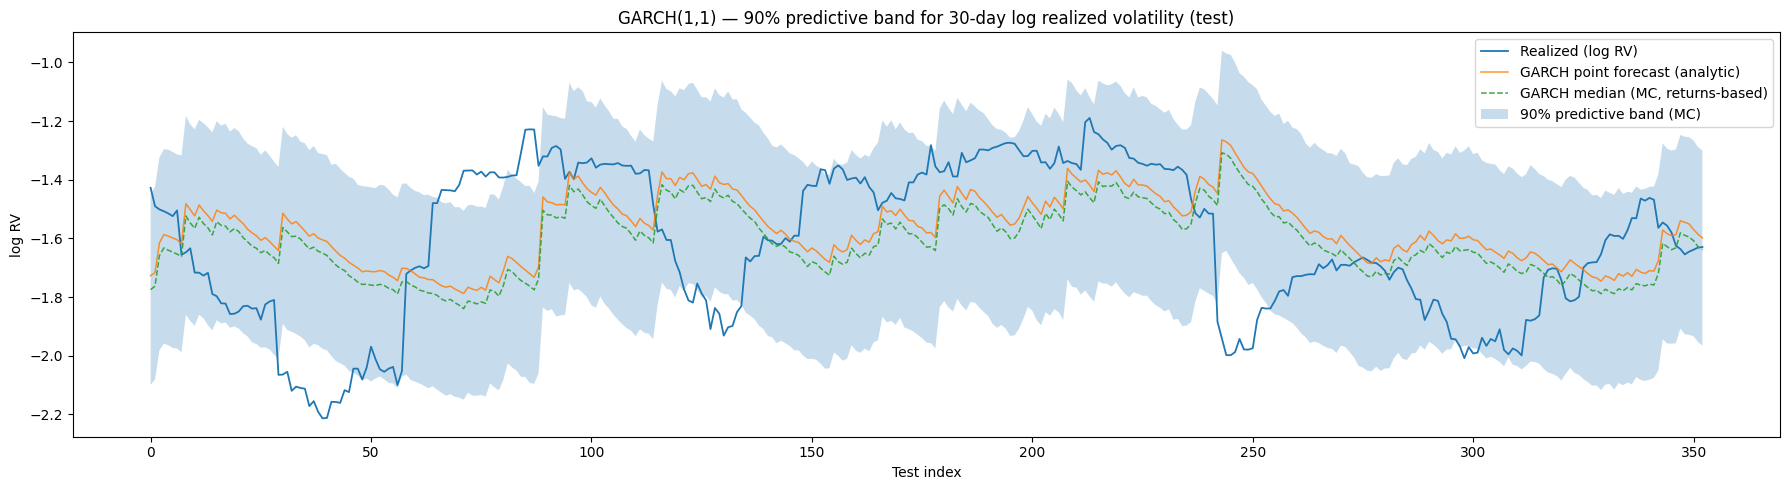

[MC band] 90% coverage on test (log): 0.807


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_garch_paths_one_stepahead(omega, alpha, beta, sigma2_t, H=30, M=2000, rng_seed=None, dist="normal", nu=8.0):
    rng = np.random.default_rng(rng_seed)
    if dist == "normal":
        z = rng.standard_normal((M, H))
    elif dist == "t":
        z = rng.standard_t(df=nu, size=(M, H)) * np.sqrt((nu - 2.0) / nu)  # unit var
    else:
        raise ValueError("dist must be 'normal' or 't'")
    sig2 = np.empty((M, H), float)
    eps  = np.empty((M, H), float)
    s = np.full(M, sigma2_t, float)
    for h in range(H):
        e = np.sqrt(s) * z[:, h]          # innovations
        s = omega + alpha*(e**2) + beta*s 
        sig2[:, h] = s
        eps[:,  h] = e
    return sig2, eps

def realized_logvol_from_eps_paths(eps_paths):
    avg_var = np.mean(eps_paths**2, axis=1)          
    vol     = np.sqrt(avg_var) * np.sqrt(252.0)      # annualize
    return np.log(vol + 1e-8)

# ---- settings ----
alpha_band = 0.10
q_lo, q_hi = alpha_band/2, 1 - alpha_band/2
H_sim      = 30
M_paths    = 10000
dist_sim   = "normal"  
nu_df      = 8.0

n_te = len(test_idx)
pred_lo_log  = np.empty(n_te); pred_lo_log[:]  = np.nan
pred_hi_log  = np.empty(n_te); pred_hi_log[:]  = np.nan
pred_med_log = np.empty(n_te); pred_med_log[:] = np.nan

sigma2_curr = float(res.conditional_volatility[-1]**2)

for i, t in enumerate(test_idx):
    r_prev = returns[t-1]
    if not np.isfinite(r_prev) or not np.isfinite(sigma2_curr):
        pred_lo_log[i] = pred_hi_log[i] = pred_med_log[i] = np.nan
        continue

    sigma2_curr = omega + alpha*(r_prev**2) + beta*sigma2_curr

    _, eps_paths = simulate_garch_paths_one_stepahead(
        omega, alpha, beta, sigma2_curr, H=H_sim, M=M_paths,
        rng_seed=12345 + i, dist=dist_sim, nu=nu_df
    )
    samp_logvol = realized_logvol_from_eps_paths(eps_paths)

    pred_lo_log[i]  = np.nanquantile(samp_logvol, q_lo)
    pred_hi_log[i]  = np.nanquantile(samp_logvol, q_hi)
    pred_med_log[i] = np.nanquantile(samp_logvol, 0.5)

t_axis = np.arange(n_te)
mask = np.isfinite(pred_lo_log) & np.isfinite(pred_hi_log) & np.isfinite(pred_med_log) & np.isfinite(realized_log_vol)

plt.figure(figsize=(18,5))
plt.plot(t_axis[mask], realized_log_vol[mask], label="Realized (log RV)", linewidth=1.3)
if "log_vol_preds" in globals() and len(log_vol_preds) == n_te:
    plt.plot(t_axis[mask], log_vol_preds[mask], label="GARCH point forecast (analytic)", linewidth=1.1, alpha=0.85)
plt.plot(t_axis[mask], pred_med_log[mask], label="GARCH median (MC, returns-based)", linewidth=1.1, linestyle="--", alpha=0.9)
plt.fill_between(t_axis[mask], pred_lo_log[mask], pred_hi_log[mask], alpha=0.25, label="90% predictive band (MC)")
plt.title("GARCH(1,1) — 90% predictive band for 30-day log realized volatility (test)")
plt.xlabel("Test index"); plt.ylabel("log RV"); plt.legend(); plt.tight_layout()
plt.savefig("plots/garch/test_band_log.png", dpi=160)
plt.show()

mask = np.isfinite(realized_log_vol) & np.isfinite(pred_lo_log) & np.isfinite(pred_hi_log)
coverage_90 = np.mean((realized_log_vol[mask] >= pred_lo_log[mask]) & (realized_log_vol[mask] <= pred_hi_log[mask]))
print(f"[MC band] 90% coverage on test (log): {coverage_90:.3f}")


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def interval_score(alpha, l, u, y):
    """Central (1-alpha) interval score (lower is better)."""
    width = u - l
    under = (l - y) if y < l else 0.0
    over  = (y - u) if y > u else 0.0
    return width + (2.0/alpha) * under + (2.0/alpha) * over

def crps_from_samples(samples, y):
    """CRPS estimator from i.i.d. samples (lower is better)."""
    x = np.asarray(samples, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0 or not np.isfinite(y):
        return np.nan
    term1 = np.mean(np.abs(x - y))
    term2 = 0.5 * np.mean(np.abs(x[:, None] - x[None, :]))
    return term1 - term2

# Point accuracy
metrics = {}
m_point = np.isfinite(realized_log_vol)
if "log_vol_preds" in globals() and len(log_vol_preds) == len(realized_log_vol):
    m_point = m_point & np.isfinite(log_vol_preds)
    mae_log = mean_absolute_error(realized_log_vol[m_point], log_vol_preds[m_point])
    mse_log = mean_squared_error(realized_log_vol[m_point], log_vol_preds[m_point])
    metrics["MAE_log_point"] = mae_log
    metrics["MSE_log_point"] = mse_log
    print(f"[Point] MAE (log): {mae_log:.6f}   MSE (log): {mse_log:.6f}")
else:
    print("[Point] Skipped: 'log_vol_preds' not available or length mismatch.")

# Distributional metrics 
alpha = 0.10  # 90% band
m_band = np.isfinite(realized_log_vol) & np.isfinite(pred_lo_log) & np.isfinite(pred_hi_log)

coverage_90 = np.mean((realized_log_vol[m_band] >= pred_lo_log[m_band]) &
                      (realized_log_vol[m_band] <= pred_hi_log[m_band]))
avg_width_90 = np.nanmean((pred_hi_log[m_band] - pred_lo_log[m_band]))

is_90 = np.nanmean([
    interval_score(alpha, pred_lo_log[i], pred_hi_log[i], realized_log_vol[i])
    for i in np.where(m_band)[0]
])

metrics["Coverage90"]   = coverage_90
metrics["AvgWidth90"]   = avg_width_90
metrics["IntervalScore90"] = is_90

print(f"[Dist]  Coverage 90% (log):  {coverage_90:.3f}")
print(f"[Dist]  Avg width 90% (log): {avg_width_90:.6f}")
print(f"[Dist]  Interval score 90%:  {is_90:.6f}")

M_CRPS   = 4000
dist_sim = "normal"  
nu_df    = 8.0

crps_vals = np.full(len(test_idx), np.nan, dtype=float)

sigma2_curr = float(res.conditional_volatility[-1]**2)

for i, t in enumerate(test_idx):
    r_prev = returns[t-1]
    if not (np.isfinite(r_prev) and np.isfinite(sigma2_curr) and np.isfinite(realized_log_vol[i])):
        continue

    sigma2_curr = omega + alpha*(r_prev**2) + beta*sigma2_curr

    _, eps_paths = simulate_garch_paths_one_stepahead(
        omega, alpha, beta, sigma2_curr, H=H_sim, M=M_CRPS,
        rng_seed=20240831 + i, dist=dist_sim, nu=nu_df
    )
    samp_logvol = realized_logvol_from_eps_paths(eps_paths)
    crps_vals[i] = crps_from_samples(samp_logvol, realized_log_vol[i])

crps_log = float(np.nanmean(crps_vals))
metrics["CRPS_log"] = crps_log
print(f"[Dist]  CRPS (log):          {crps_log:.6f}")

import pandas as pd, os
os.makedirs("plots", exist_ok=True)
row = {
    "Model": "GARCH(1,1)",
    "MAE_log": metrics.get("MAE_log_point", np.nan),
    "MSE_log": metrics.get("MSE_log_point", np.nan),
    "CRPS_log": metrics["CRPS_log"],
    "Coverage90": metrics["Coverage90"],
    "AvgWidth90": metrics["AvgWidth90"],
    "IntervalScore90": metrics["IntervalScore90"],
}
df_metrics = pd.DataFrame([row])
df_metrics.to_csv("plots/garch/test_metrics_log.csv", index=False)
print("[Saved] plots/garch/test_metrics_log.csv")


[Point] MAE (log): 0.218454   MSE (log): 0.072081
[Dist]  Coverage 90% (log):  0.807
[Dist]  Avg width 90% (log): 0.667790
[Dist]  Interval score 90%:  1.122584


[Dist]  CRPS (log):          0.374438
[Saved] plots/garch/test_metrics_log.csv


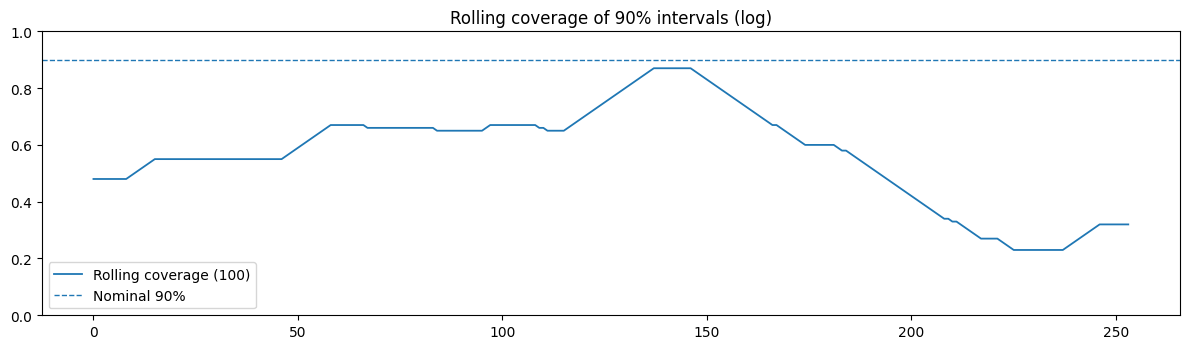

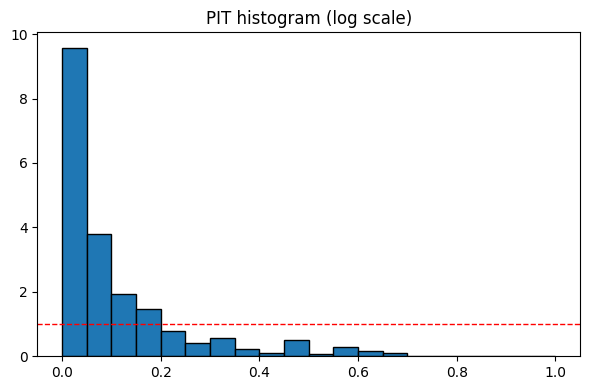

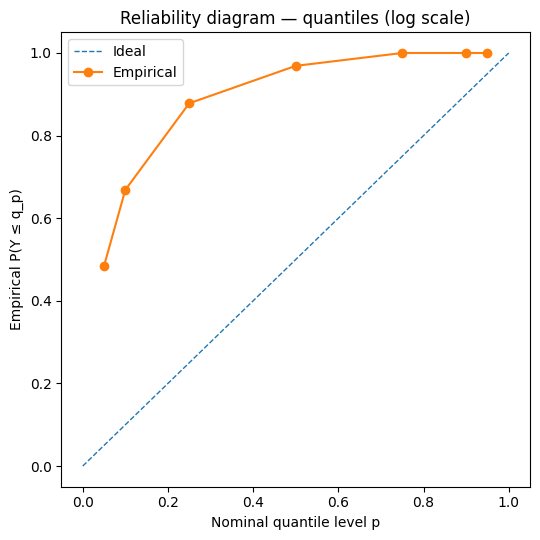

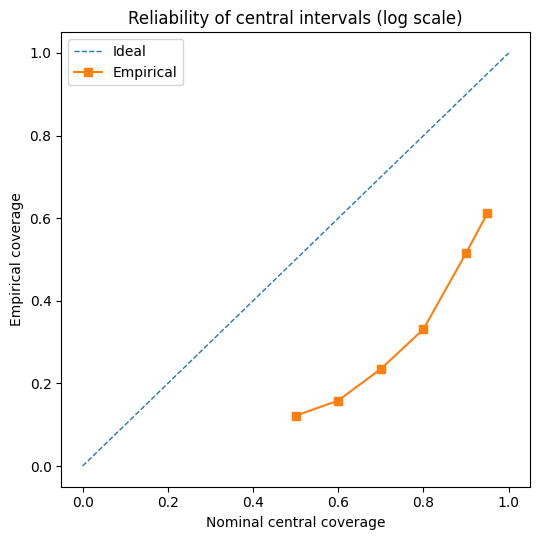

In [ ]:
import numpy as np, os, matplotlib.pyplot as plt
os.makedirs("plots", exist_ok=True)

# ---------- knobs ----------
WIN                 = 100          # rolling window for coverage-by-time
H_mc                = 30           # horizon (days)
M_mc                = 4000         # sims per test origin (balance speed / stability)
dist_mc             = "normal"     # or 't'
nu_df               = 8.0          # used if dist_mc == 't'
quantile_grid       = np.array([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])
central_cover_grid  = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95])  # central intervals

n_te = len(test_idx)
logrv_samples_list = [None] * n_te    

sigma2_curr = float(res.conditional_volatility[-1]**2)  

for i, t in enumerate(test_idx):
    r_prev = returns[t-1]
    if not (np.isfinite(r_prev) and np.isfinite(sigma2_curr) and np.isfinite(realized_log_vol[i])):
        logrv_samples_list[i] = np.array([], dtype=float)
        continue

    sigma2_curr = omega + alpha*(r_prev**2) + beta*sigma2_curr

    _, eps_paths = simulate_garch_paths_one_stepahead(
        omega, alpha, beta, sigma2_curr, H=H_mc, M=M_mc,
        rng_seed=20240901 + i, dist=dist_mc, nu=nu_df
    )
    samp_logvol = realized_logvol_from_eps_paths(eps_paths)  # (M_mc,)
    logrv_samples_list[i] = samp_logvol[np.isfinite(samp_logvol)]

alpha = 0.10
q_lo, q_hi = alpha/2, 1 - alpha/2

pred_lo = np.full(n_te, np.nan)
pred_hi = np.full(n_te, np.nan)

for i in range(n_te):
    s = logrv_samples_list[i]
    if s.size >= 50:  # enough samples
        pred_lo[i] = np.quantile(s, q_lo)
        pred_hi[i] = np.quantile(s, q_hi)

mask_band = np.isfinite(realized_log_vol) & np.isfinite(pred_lo) & np.isfinite(pred_hi)
covered  = np.zeros(n_te, dtype=float)
covered[mask_band] = ((realized_log_vol[mask_band] >= pred_lo[mask_band]) &
                      (realized_log_vol[mask_band] <= pred_hi[mask_band])).astype(float)

if WIN <= n_te:
    kernel = np.ones(WIN) / WIN
    roll_cov = np.convolve(np.where(np.isfinite(covered), covered, 0.0), kernel, mode="valid")
else:
    roll_cov = np.array([])

plt.figure(figsize=(12,3.6))
if roll_cov.size > 0:
    plt.plot(roll_cov, linewidth=1.3, label=f"Rolling coverage ({WIN})")
plt.axhline(1 - alpha, linestyle="--", linewidth=1.0, label="Nominal 90%")
plt.ylim(0, 1)
plt.title("Rolling coverage of 90% intervals (log)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/garch/calibration_coverage_by_time.png", dpi=160)
plt.show()

# PIT histogram 
pit_vals = []
for i in range(n_te):
    s = logrv_samples_list[i]
    y = realized_log_vol[i]
    if s.size == 0 or not np.isfinite(y): 
        continue
    # Rank-based PIT with mid-rank tie handling
    less = np.sum(s < y)
    equal = np.sum(s == y)
    U = (less + 0.5*equal) / float(len(s))
    pit_vals.append(U)

pit_vals = np.array(pit_vals, dtype=float)

plt.figure(figsize=(6,4))
plt.hist(pit_vals, bins=20, range=(0,1), density=True, edgecolor="k")
plt.axhline(1.0, color="r", linestyle="--", linewidth=1.0)
plt.title("PIT histogram (log scale)")
plt.tight_layout()
plt.savefig("plots/garch/pit_histograms.png", dpi=160)
plt.show()

# Reliability diagram — quantiles 
nominal_ps = quantile_grid
empirical_ps = []

for p in nominal_ps:
    count, denom = 0, 0
    for i in range(n_te):
        s = logrv_samples_list[i]
        y = realized_log_vol[i]
        if s.size == 0 or not np.isfinite(y): 
            continue
        q = np.quantile(s, p)
        denom += 1
        count += (y <= q)
    empirical_ps.append(count / denom if denom > 0 else np.nan)

empirical_ps = np.array(empirical_ps, dtype=float)

plt.figure(figsize=(5.5,5.5))
xx = np.linspace(0,1,201)
plt.plot(xx, xx, linestyle="--", linewidth=1.0, label="Ideal")
plt.plot(nominal_ps, empirical_ps, marker="o", linewidth=1.5, label="Empirical")
plt.xlabel("Nominal quantile level p")
plt.ylabel("Empirical P(Y ≤ q_p)")
plt.title("Reliability diagram — quantiles (log scale)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/garch/reliability_quantiles.png", dpi=160)
plt.show()

# Reliability — central intervals 
nominal_covs = central_cover_grid
empirical_covs = []

for c in nominal_covs:
    a = (1 - c) / 2.0
    b = 1 - a
    count, denom = 0, 0
    for i in range(n_te):
        s = logrv_samples_list[i]
        y = realized_log_vol[i]
        if s.size == 0 or not np.isfinite(y): 
            continue
        lo = np.quantile(s, a)
        hi = np.quantile(s, b)
        denom += 1
        count += (y >= lo) and (y <= hi)
    empirical_covs.append(count / denom if denom > 0 else np.nan)

empirical_covs = np.array(empirical_covs, dtype=float)

plt.figure(figsize=(5.5,5.5))
xx = np.linspace(0,1,201)
plt.plot(xx, xx, linestyle="--", linewidth=1.0, label="Ideal")
plt.plot(nominal_covs, empirical_covs, marker="s", linewidth=1.5, label="Empirical")
plt.xlabel("Nominal central coverage")
plt.ylabel("Empirical coverage")
plt.title("Reliability of central intervals (log scale)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/garch/reliability_central_intervals.png", dpi=160)
plt.show()
